Карпов Андрей (вариант 2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import expm, sqrtm
np.random.seed(123)

In [239]:
from numba import jit

In [240]:
def purityCalc(rho):
    '''Calculate purity of state @rho'''
    return np.trace(rho.dot(rho))

def Fidelity(rho_0, rho_1):
    '''
    calculate Fidelity of @rho_0 and @rho_1
    '''
    
    #sqrt_rho_0 = sqrtm(rho_0)
    sqrt_rho_0 = sp.linalg.sqrtm(rho_0)
    F = np.trace(sqrtm(sqrt_rho_0 @ rho_1 @ sqrt_rho_0))**2
    return F

#@jit(parallel=True)
def Fidelity_evol(rho_0, rho_t, t):
    F = np.zeros_like(t, dtype=np.float64)
    for i in range(t.shape[0]):
        F[i] = Fidelity(rho_0, rho_t[i])
        
    return F

Рассчитаем эволюцию под действием гамильтониана 
$$\hat{H} = \pi\hat\sigma_z + \frac{5\pi}{2}\cos(5t)\hat\sigma_x$$
$t \in [0;2]$

In [241]:
# generation of mixed state

d = 2
k = 10

psi = np.array([np.random.normal(0, 1, d*k) + 1j*np.random.normal(0, 1, d*k)])
norm = np.sqrt(np.sum(np.abs(psi)**2))
psi /= norm

pure_rho = np.outer(psi, psi.conj())
mixed_rho = np.trace(pure_rho.reshape(d,k,d,k), axis1=1, axis2=3) # trace on subsystem

In [242]:
# check state is mexed or not
purity = purityCalc(mixed_rho)
print("Чистота состояния: " , np.round(purity.real,3))

Чистота состояния:  0.561


#### Уравнение Фон Неймана

In [243]:
sigma_z = np.array([[1,0],
                  [0,-1]], dtype=np.complex64)
sigma_y = np.array([[0,-1j],
                  [1j,0]], dtype=np.complex64)
sigma_x = np.array([[0,1],
                  [1,0]], dtype=np.complex64)
identity = np.array([[1,0],
                  [0,1]], dtype=np.complex64)

sigma_array = [identity, sigma_x, sigma_y, sigma_z]

def H(t):
    return np.pi*sigma_z + 5*np.pi/2*np.cos(t)*sigma_x

def commutator(A,B):
    return A@B - B@A

def von_Neumann_evolution(t, H, rho_0):
    '''
    calculate time evolution of @rho_0 using von Neumann equation on grid @t 
    @H -- function H(t, args)
    '''
    rho_t = np.zeros((t.shape[0], rho_0.shape[0], rho_0.shape[1]), dtype=np.complex64)
    rho_t[0] = rho_0
    dt = t[1]-t[0]
    
    for n in range(t.shape[0]-1):
        rho_t[n+1] = rho_t[n] +  dt*1j*commutator(rho_t[n], H(t[n]))
        
    return rho_t

In [244]:
%%time
t_final = 2
t_start = 0
dt_arr = np.array([1e-1, 1e-2, 1e-3])
n_iter = 1000

t_arr = []
rho_t_arr = []
for i in range(3):
    t = np.linspace(t_start, t_final, int((t_final-t_start)/dt_arr[i]))
    rho_t = von_Neumann_evolution(t, H, mixed_rho)
    
    t_arr.append(t)
    rho_t_arr.append(rho_t)

Wall time: 36 ms


C:\Users\duhak\AppData\Local\Temp/ipykernel_15552/1109351770.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])
C:\Users\duhak\AppData\Local\Temp/ipykernel_15552/1109351770.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])
C:\Users\duhak\AppData\Local\Temp/ipykernel_15552/1109351770.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])


Wall time: 243 ms


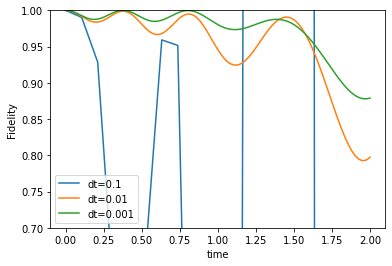

In [245]:
%%time
for i in range(3):
    y = Fidelity_evol(mixed_rho, rho_t_arr[i], t_arr[i])
    plt.plot(t_arr[i], y, label=f"dt={dt_arr[i]}")
    
plt.ylim(0.7, 1)
plt.xlabel("time")
plt.ylabel("Fidelity")
plt.legend()

Как видно метод обладает не самой лучшей сходимостью

#### Оператор эволюции

In [144]:
def Heizenberg_evolution(t, H, rho_0):
    '''
    calculate time evolution of @rho_0 using Heizenberg equation on grid @t 
    @H -- function H(t, args)
    '''
    rho_t = np.zeros((t.shape[0], rho_0.shape[0], rho_0.shape[1]), dtype=np.complex64)
    rho_t[0] = rho_0
    
    dt = t[1] - t[0]
    
    for n in range(t.shape[0]-1):
        U = expm(-1j*H(t[n])*dt)
        rho_t[n+1] = U @ rho_t[n] @ U.T.conj() 
        
    return rho_t

In [149]:
t = np.linspace(t_start, t_final, n_iter)
dt = t[1] - t[0]
rho_t_Heiz =  Heizenberg_evolution(t, H, mixed_rho)

In [150]:
rho_t_Heiz.shape

(1000, 2, 2)

C:\Users\duhak\AppData\Local\Temp/ipykernel_15552/2849458647.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])
C:\Users\duhak\AppData\Local\Temp/ipykernel_15552/2849458647.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])


Text(0, 0.5, 'Fidelity')

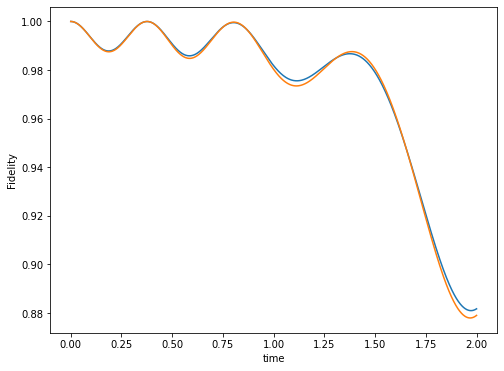

In [154]:
plt.figure(figsize=(8,6))
plt.plot(t, Fidelity_evol(mixed_rho, rho_t_Heiz, t), label="Method of Heizenberg evolution")
plt.plot(t_arr[2], Fidelity_evol(mixed_rho, rho_t_arr[2], t_arr[2]), label="Method of von Neumann evolution")
plt.xlabel("time")
plt.ylabel("Fidelity")

### Задание№2

In [37]:
def DepolarizedNoise(p):
    E0 = 2*np.sqrt(1-3*p)/2*np.identity(2)
    E1 = 2*np.sqrt(p)/2*sigma_x
    E2 = 2*np.sqrt(p)/2*sigma_y
    E3 = 2*np.sqrt(p)/2*sigma_z
    
    return E0, E1, E2, E3

In [38]:
p = 0.15
E0, E1, E2, E3 = DepolarizedNoise(p)
E = [E0, E1, E2, E3]

#### Матрица Чоя-Ямилковкого

In [178]:
for i in range(len(E)):
    
    s = E[i].shape[0]
    e_i = E[i].reshape(s**2,1)
    
    if i==0:
        e = e_i.copy()
        continue
        
    e = np.concatenate((e, e_i), axis=1)
    
xi = e @ e.T.conj()

In [179]:
xi

array([[0.70000001+0.j, 0.        +0.j, 0.        +0.j, 0.39999999+0.j],
       [0.        +0.j, 0.30000002+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.30000002+0.j, 0.        +0.j],
       [0.39999999+0.j, 0.        +0.j, 0.        +0.j, 0.70000001+0.j]])

Проверим, что матрица единичная

In [41]:
np.trace(xi.reshape(2,2,2,2), axis1=1, axis2=3)

array([[1.00000003+0.j, 0.        +0.j],
       [0.        +0.j, 1.00000003+0.j]])

In [180]:
def Craus(rho_in, E):8
    rho_out = np.zeros_like(rho_in)
    
    for j in range(len(E)):
        rho_out += E[j] @ rho_in @ E[j].T.conj()
            
    return rho_out

def Choy_Yamilkosky(rho_in, xi):
    rho_out = np.zeros_like(rho_in)
    
    s1 = np.array([[1,0],[0,0]])
    s2 = np.array([[0,1],[0,0]])
    s3 = np.array([[0,0],[1,0]])
    s4 = np.array([[0,0],[0,1]])
    s = [s1,s2,s3,s4]
    
    for i in range(len(s)):
        for j in range(len(s)):
            rho_out += xi[i][j] * s[i] @ rho_in @ s[j].T
            
    return rho_out

def Evolition_operator(rho_in, E):
    s1, s2 = rho_in.shape
    rho_temp = rho_in.copy()
    rho_temp = rho_temp.reshape(s1*s2)
    
    G = np.zeros((E[0].shape[0]**2, E[0].shape[0]**2), dtype=np.complex64)
    for i in range(len(E)):
        G += np.kron(E[i].conj(), E[i])
        
    return np.dot(G, rho_temp).reshape(s1,s2)

In [181]:
len(sigma_array)

4

Эволюция с помощью матрицы Чоя-Ямилковского

In [182]:
rho_out_1 = Choy_Yamilkosky(mixed_rho, xi)
rho_out_1

array([[ 0.49489103+0.j        , -0.06926223+0.00653895j],
       [-0.06926223-0.00653895j,  0.505109  +0.j        ]])

Эволюция с помощью операторов Крауса

In [177]:
rho_out_2 = Craus(mixed_rho, E)
rho_out_2

array([[ 0.49489103+0.j        , -0.06926223+0.00653895j],
       [-0.06926223-0.00653895j,  0.505109  +0.j        ]])

Эволюция с помощью оператора эволюции

In [79]:
rho_out_3 = Evolition_operator(mixed_rho, E)
rho_out_3

array([[ 0.49489104+0.j        , -0.06926223+0.00653895j],
       [-0.06926223-0.00653895j,  0.50510902+0.j        ]])

In [155]:
mixed_rho.reshape(1,4)

array([[ 0.48722754+0.j        , -0.17315557+0.01634739j,
        -0.17315557-0.01634739j,  0.51277246+0.j        ]])

In [171]:
Psi = 1/np.sqrt(2)*np.array([1.,0.,0.,1.], dtype=np.complex64)
bell_rho = np.outer(Psi, Psi.conj())
E_extend = []

for i in range(4):
    E_extend.append(np.kron(identity, E[i]))

xi_2 = 2*Craus(bell_rho, E_extend)
xi_2

array([[0.6999999 +0.j, 0.        +0.j, 0.        +0.j, 0.39999998+0.j],
       [0.        +0.j, 0.29999998+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.29999998+0.j, 0.        +0.j],
       [0.39999998+0.j, 0.        +0.j, 0.        +0.j, 0.6999999 +0.j]],
      dtype=complex64)